# Imports

In [1]:
# Python standard library
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Load data

In [3]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_1/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events.json'

In [4]:
# Load video
oi_res_x = 512
oi_res_y = 288
oi_fps = 100000.
oi_vid = oi_file.Video(oi_vid_file_path, oi_res_x, oi_res_y, oi_fps)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


## Load ellipses

In [5]:
oi_ellipse_base_path = '../data/'
oi_ellipse_path = oi_ellipse_base_path + date + particle + channel + 'ellipses_' + file_index

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

### Filter

In [6]:
# Load keep indices
filter_file_path = '../data/' + date + particle + channel + 'filter_' + file_index

with open(filter_file_path, 'r') as filter_file_handle:
    filter_file_reader = csv.reader(filter_file_handle, delimiter = '\t')
    for row in filter_file_reader:
        if row[0] == 'events':
            keep_indices = [int(ele) for ele in row[1:]]

print 'loaded keep indices (', len(keep_indices), 'events total):\n', keep_indices

loaded keep indices ( 45 events total):
[0, 7, 10, 15, 18, 19, 22, 24, 25, 31, 34, 40, 41, 45, 47, 49, 52, 56, 59, 63, 64, 66, 71, 72, 78, 80, 81, 86, 87, 91, 98, 100, 102, 108, 109, 112, 114, 115, 123, 125, 126, 138, 140, 147, 154]


In [7]:
filtered_oi_events = [oi_events[i] for i in range(len(oi_events)) if i in keep_indices]
filtered_oi_ellipsess = [ellipsess[i] for i in range(len(ellipsess)) if i in keep_indices]

In [8]:
oi_index = 102

oi_event = filtered_oi_events[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_event._detections[0]._tf, oi_event._detections[-1]._tf, oi_fps).to_html5_video())

IndexError: list index out of range

## Load template and create stage

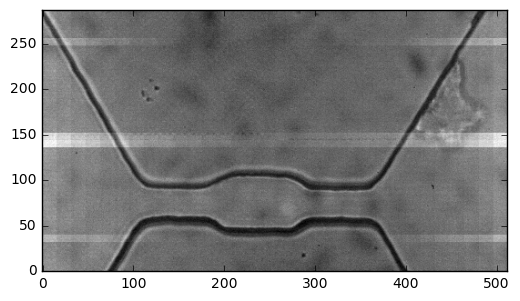

In [9]:
template_index = 0

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[-0.  1.]


/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:429: RuntimeWarning: divide by zero encountered in double_scalars
  plt.plot([x, x + image_height/(self._norm_y[1]/self._norm_y[0])], [0, image_height], ls = '--', color = 'yellow')


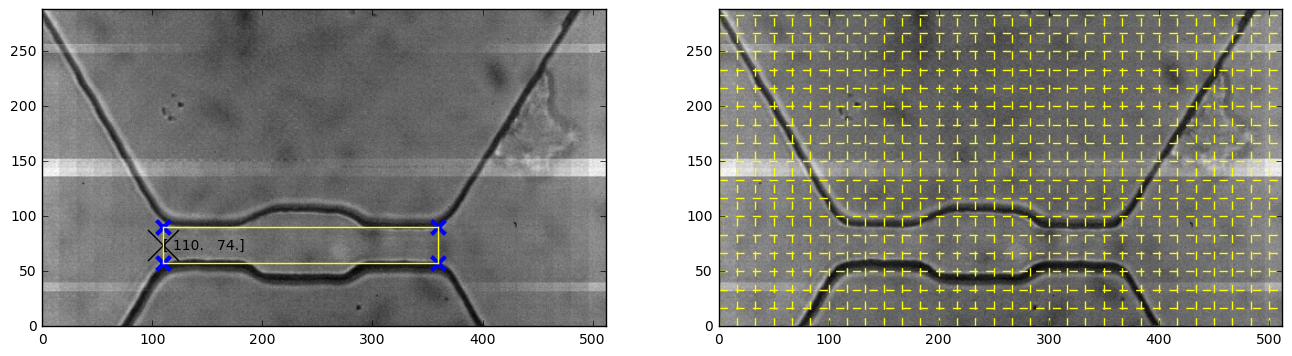

In [11]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [110,90]
c1 = [110,58]
c2 = [360,58]
c3 = [360,90]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Calculate average velocity

In [14]:
oi_index = 3
oi_event = filtered_oi_events[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_event._detections[0]._tf, oi_event._detections[-1]._tf).to_html5_video())

TypeError: make_animation() takes exactly 4 arguments (3 given)

In [12]:
velocities = []

for i, ellipses in enumerate(filtered_oi_ellipsess):
    
    ts = []
    xs = []
    ys = []
    
    
    for ellipse in ellipses:
        detection_index = ellipse[0]
        ts.append(detection_index)
        #ts.append(oi_events[i]._detections[int(detection_index)]._tf)
        xs.append(ellipse[1])
        ys.append(ellipse[2])
        
    ts = np.array(ts)
    ts = ts/oi_fps
    xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
    xcs = oi_stage.pixels_to_meters(xcs)
    

    ts_interp = scipy.interpolate.interp1d(xcs, ts)
    
    dx = oi_stage._length_microns*10**(-6.)
    dt = ts_interp(oi_stage._length_microns) - ts_interp(0)


    velocities.append(dx/dt)

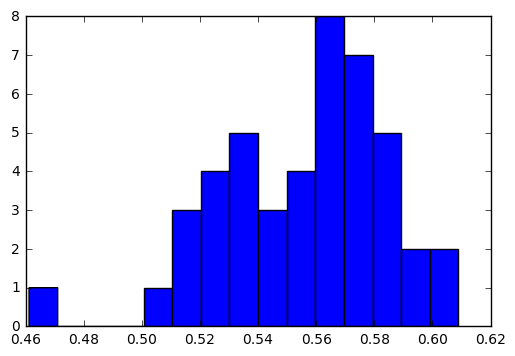

In [13]:
plt.hist(velocities, bins = 15)
plt.show()

## Save data

In [14]:
# Check output file path

output_file_path = '../data/' + date + particle + channel + 'velocities_' + file_index
print output_file_path

../data/7-17-2017/293-T/15-30-15_1/velocities_0


In [15]:
with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    # Write header
    file_writer.writerow([date + particle + channel + 'velocities_' + file_index])
    
    # Write data
    for i in range(len(velocities)):
        file_writer.writerow(['event #', i])
        file_writer.writerow([round(velocities[i], 5)])